In [2]:
############# Loading ##############

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb

# Evaluation metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape

epsoln = 1e-9  # Define a small epsilon value for division by zero cases

def rmse(y_true, y_pred):
  return np.sqrt(mse(y_true, y_pred))

def pbe(y_true, y_pred):
  if np.sum(y_true)!=0:
    return 100*(np.sum(y_pred - y_true)/np.sum(y_true))
  else:
    return 100*(np.sum(y_pred - y_true)/(np.sum(y_true)+epsoln))

def pocid(y_true, y_pred):
    n = len(y_true)
    D = [1 if (y_pred[i] - y_pred[i-1]) * (y_true[i] - y_true[i-1]) > 0 else 0 for i in range(1, n)]
    POCID = 100 * np.sum(D) / n
    return POCID

def mcpm(rmse_result, mape_result, pocid_result):
  er_result = 100 - pocid_result

  A1 = (rmse_result * mape_result * np.sin((2*np.pi)/3))/2
  A2 = (mape_result * er_result * np.sin((2*np.pi)/3))/2
  A3 = (er_result * rmse_result * np.sin((2*np.pi)/3))/2
  total = A1 + A2 + A3
  return total

def znorm(x):
  if np.std(x) != 0: 
      x_znorm = (x - np.mean(x)) / np.std(x)
  else:
      x_znorm = (x - np.mean(x)) / (np.std(x) + epsoln)
  return x_znorm

def znorm_reverse(x, mean_x, std_x):
  x_denormalized = (np.array(x) * std_x) + mean_x
  return x_denormalized

def get_stats_norm(series, horizon, window):
  last_subsequence = series[-(horizon+window):-horizon].values
  last_mean = np.mean(last_subsequence)
  last_std = np.std(last_subsequence)
  return last_mean, last_std

# Em geral, considera-se um tamanho de janela capaz de capturar um ciclo dos dados
# Por exemplo, 12 observações no caso dos dados com frequência mensal
def rolling_window(series, window):
  data = []
  for i in range(len(series)-window):
    # example = znorm(np.array(series[i:i+window+1]))
    example = (np.array(series[i:i+window+1]))
    data.append(example)
  df = pd.DataFrame(data)
  return df

def rolling_window_12(series, window):
  data = []
  for i in range(len(series)-window):
    example = znorm(np.array(series[i:i+window+12]))
    data.append(example)
  df = pd.DataFrame(data)
  return df


# Para predição de vendas por UF (mensal), será considerado horizon = 12
# Para predição de vendas por município (anual), será considerado horizon = 1
def train_test_split(data, horizon):
  X = data.iloc[:,:-1] # features
  y = data.iloc[:,-1] # target

  X_train = X[:-horizon] # features train
  X_test =  X[-horizon:] # features test

  y_train = y[:-horizon] # target train
  y_test = y[-horizon:] # target test
  return X_train, X_test, y_train, y_test

def recursive_multistep_forecasting(X_test, model, horizon):
  # example é composto pelas últimas observações vistas
  # na prática, é o pbeprimeiro exemplo do conjunto de teste
  example = X_test.iloc[0].values.reshape(1,-1)

  preds = []
  for i in range(horizon):
    pred = model.predict(example)[0]
    preds.append(pred)

    # Descartar o valor da primeira posição do vetor de características
    example = example[:,1:]

    # Adicionar o valor predito na última posição do vetor de características
    example = np.append(example, pred)
    example = example.reshape(1,-1)
  return preds

def targeted_forecasting(X_test, model):
  # example é composto pelas últimas observações vistas
  # na prática, é o pbeprimeiro exemplo do conjunto de teste
  example = X_test.iloc[0].values.reshape(1,-1)

  preds = []
  for i in range(1):
    pred = model.predict(example)[0]
    preds.append(pred)

    # Descartar o valor da primeira posição do vetor de características
    example = example[:,1:]

    # Adicionar o valor predito na última posição do vetor de características
    example = np.append(example, pred)
    example = example.reshape(1,-1)
  return preds

def baseline_mean(series, horizon):
  # como as séries são normalizadas, esse baseline irá retornar uma reta próxima de zero
  pred = np.repeat(np.mean(znorm(series[:-horizon])), horizon)
  return pred

def baseline_persistent(series, horizon):
  return np.repeat(znorm(series[-2*horizon:-horizon]).values[-1], horizon)

def baseline_persistent_window(series, horizon):
  subsequence = znorm(series[-horizon*2:-horizon]).values
  return subsequence


In [3]:
######### Lista Estados ##############

import os
import csv

def extract_estado(file_name):
    # Split the file name by underscores
    parts = file_name.split('_')
    # Extract the name between underscores
    estado = parts[1]
    return estado

def read_csv_files(folder_path):
    estados = []
    # List all files in the folder
    files = os.listdir(folder_path)
    # Iterate through each file
    for file_name in files:
        # Check if it's a CSV file
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            # Open the CSV file and read the data
            with open(file_path, 'r', newline='') as csvfile:
                reader = csv.reader(csvfile)
                # Assuming the first row contains headers
                headers = next(reader)
                # Extract estado from file name and append to estados list
                estado = extract_estado(file_name)
                estados.append(estado)
                estados.sort()
    return estados

# Specify the folder path where CSV files are located


In [71]:
############ TEST #################

######### Regressors #######################

products = sorted([name for name in os.listdir('./') if os.path.isdir(os.path.join('./', name))])

horizon = 12
window = 12

product = 'gasolinac'
estado = 'sp'


# carregamento do arquivo
df = pd.read_csv(f"./{product}/mensal_{estado}_{product}.csv", header=0, sep=";")

series = df["m3"]

# Parâmetros
# - horizon: horizonte de predição >> Padrão 12
# - window: comprimento da janela para a geração da tabela atributo-valor >> Padrão 12

# Geração da tabela atributo-valor (normalizado)
# data = rolling_window_12(series, window)

data = rolling_window(series, window+11)
# List to store the new datasets
datasets = []

# Iterate over the range of columns from 13 to 24
for i in range(13, 25):
    # Create a new DataFrame with the first 12 columns and the column at the current position
    new_df = data.iloc[:, list(range(12)) + [i - 1]]
    datasets.append(new_df)

# Display the first dataset to verify
# print(datasets[0])

indices1 = ""
indices2 = ""
indices3 = ""
indices4 = ""
indices5 = ""
indices6 = ""
indices7 = ""

out_pred = []

for u in range(12):

    
    # Divisão dos dados em treino/teste considerando o horizonte de predição de 12 meses
    X_train, X_test, y_train, y_test = train_test_split(datasets[u], horizon)

    ############################################# lgb
    num_round = 100

    # Convert data to LightGBM dataset format
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    ############################################

    ############## Regressores ##################
    # regr1 = LinearRegression()
    regr2 = KNeighborsRegressor(n_neighbors = 3)
    regr3 = XGBRegressor()
    regr4 = SVR(kernel='rbf')
    regr5 = RandomForestRegressor()
    # regr6 = MLPRegressor(random_state=1, activation='relu', max_iter=500)
    regr7 = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                            num_leaves=31, learning_rate=0.05, feature_fraction=0.9,
                            bagging_fraction=0.8, bagging_freq=5, verbose=-1)

    # Treinamento dos modelos
    # regr1.fit(X_train, y_train)
    # predictions1a = recursive_multistep_forecasting(X_test, regr1, horizon)
    # regr2.fit(X_train, y_train)
    # predictions2a = recursive_multistep_forecasting(X_test, regr2, 1)
    # regr3.fit(X_train, y_train)
    # predictions3a = recursive_multistep_forecasting(X_test, regr3, horizon)
    # regr4.fit(X_train, y_train)
    # predictions4a = recursive_multistep_forecasting(X_test, regr4, horizon)
    # regr5.fit(X_train, y_train)
    # predictions5a = recursive_multistep_forecasting(X_test, regr5, horizon)
    # # regr6.fit(X_train, y_train)
    # # predictions6a = recursive_multistep_forecasting(X_test, regr6, horizon)
    # regr7.fit(X_train, y_train)
    # predictions7a = recursive_multistep_forecasting(X_test, regr7, horizon)



    regr2.fit(X_train, y_train)
    predictions2a = targeted_forecasting(X_test, regr2)
    regr3.fit(X_train, y_train)
    predictions3a = targeted_forecasting(X_test, regr3)
    regr4.fit(X_train, y_train)
    predictions4a = targeted_forecasting(X_test, regr4)
    regr5.fit(X_train, y_train)
    predictions5a = targeted_forecasting(X_test, regr5)
    # regr6.fit(X_train, y_train)
    # predictions6a = targeted_forecasting(X_test, regr6)
    regr7.fit(X_train, y_train)
    predictions7a = targeted_forecasting(X_test, regr7)
    
    # Recupera a média e desvio-padrão da última subsequência observada
    mean_norm, std_norm = get_stats_norm(series, horizon, window+12)

    # # Reescala a predição
    # # predictions1 = znorm_reverse(predictions1a, mean_norm, std_norm)
    predictions2 = znorm_reverse(predictions2a, mean_norm, std_norm)
    predictions3 = znorm_reverse(predictions3a, mean_norm, std_norm)
    predictions4 = znorm_reverse(predictions4a, mean_norm, std_norm)
    predictions5 = znorm_reverse(predictions5a, mean_norm, std_norm)
    # predictions6 = znorm_reverse(predictions6a, mean_norm, std_norm)
    predictions7 = znorm_reverse(predictions7a, mean_norm, std_norm)

    # Valores_Reais = series.tail(12)
    # Valores_Reais = Valores_Reais.reset_index(drop=True)

    # # mape_result1 = mape(Valores_Reais, predictions1)
    # mape_result2 = mape(Valores_Reais, predictions2)
    # mape_result3 = mape(Valores_Reais, predictions3)
    # mape_result4 = mape(Valores_Reais, predictions4)
    # mape_result5 = mape(Valores_Reais, predictions5)
    # # mape_result6 = mape(Valores_Reais, predictions6)
    # mape_result7 = mape(Valores_Reais, predictions7)

    # # pbe_result1 = pbe(Valores_Reais, predictions1)
    # pbe_result2 = pbe(Valores_Reais, predictions2)
    # pbe_result3 = pbe(Valores_Reais, predictions3)
    # pbe_result4 = pbe(Valores_Reais, predictions4)
    # pbe_result5 = pbe(Valores_Reais, predictions5)
    # # pbe_result6 = pbe(Valores_Reais, predictions6)
    # pbe_result7 = pbe(Valores_Reais, predictions7)

    # # pocid_result1 = pocid(Valores_Reais, predictions1)
    # pocid_result2 = pocid(Valores_Reais, predictions2)
    # pocid_result3 = pocid(Valores_Reais, predictions3)
    # pocid_result4 = pocid(Valores_Reais, predictions4)
    # pocid_result5 = pocid(Valores_Reais, predictions5)
    # # pocid_result6 = pocid(Valores_Reais, predictions6)
    # pocid_result7 = pocid(Valores_Reais, predictions7)
    # # 
    # # predictions1b = ', '.join(f"{item:f}" for item in predictions1)
    # predictions2b = ', '.join(f"{item:f}" for item in predictions2)
    # predictions3b = ', '.join(f"{item:f}" for item in predictions3)
    # predictions4b = ', '.join(f"{item:f}" for item in predictions4)
    # predictions5b = ', '.join(f"{item:f}" for item in predictions5)
    # # predictions6b = ', '.join(f"{item:f}" for item in predictions6)
    # predictions7b = ', '.join(f"{item:f}" for item in predictions7)


    # # import pickle
    # # with open(os.path.join(folder_path, f'{product}_{estado}_KNeighborsRegressor_{window}_model.pkl'), 'wb') as fd2:
    # #     pickle.dump(regr2, fd2)

    # # with open(os.path.join(folder_path, f'{product}_{estado}_XGBRegressor_{window}_model.pkl'), 'wb') as fd3:
    # #     pickle.dump(regr3, fd3)

    # # with open(os.path.join(folder_path, f'{product}_{estado}_SVR_{window}_model.pkl'), 'wb') as fd4:
    # #     pickle.dump(regr4, fd4)

    # # with open(os.path.join(folder_path, f'{product}_{estado}_RandomForestRegressor_{window}_model.pkl'), 'wb') as fd5:
    # #     pickle.dump(regr5, fd5)

    # # with open(os.path.join(folder_path, f'{product}_{estado}_LGBMRegressor_{window}_model.pkl'), 'wb') as fd7:
    # #     pickle.dump(regr7, fd7)
        
    # # rows_data = [
    # #     # [product,estado,'LR',fd1,mape_result1,pocid_result1,pbe_result1,p1],
    # #     [product,estado,'kNN',fd2,mape_result2,pocid_result2,pbe_result2,predictions2b],
    # #     [product,estado,'XGB',fd3,mape_result3,pocid_result3,pbe_result3,predictions3b],
    # #     [product,estado,'SVR',fd4,mape_result4,pocid_result4,pbe_result4,predictions4b],
    # #     [product,estado,'RF',fd5,mape_result5,pocid_result5,pbe_result5,predictions5b],
    # #     # [product,estado,'MLP',fd6,mape_result6,pocid_result6,pbe_result6,p6],
    # #     [product,estado,'LGB',fd7,mape_result7,pocid_result7,pbe_result7,predictions7b]             
    indices2 += str(predictions2) + " "
    indices3 += str(predictions3) + " "
    indices4 += str(predictions4) + " "
    indices5 += str(predictions5) + " "
    # indices6 += str(predictions6) + " "
    indices7 += str(predictions7) + " "


rows_data = [
    # [product,estado,'LR',fd1,mape_result1,pocid_result1,pbe_result1,p1],
    [product,estado,'kNN',indices2],
    [product,estado,'XGB',indices3],
    [product,estado,'SVR',indices4, predictions4],
    [product,estado,'RF',indices5, predictions5],
    # [product,estado,'MLP',indices6, predictions6],
    [product,estado,'LGB',indices7, predictions7],
    # [product,estado,'kNN',mape_result2,pocid_result2,pbe_result2,predictions2b],
    # [product,estado,'XGB',mape_result3,pocid_result3,pbe_result3,predictions3b],
    # [product,estado,'SVR',mape_result4,pocid_result4,pbe_result4,predictions4b],
    # [product,estado,'RF',mape_result5,pocid_result5,pbe_result5,predictions5b],
    # # [product,estado,'MLP',fd6,mape_result6,pocid_result6,pbe_result6,p6],
    # [product,estado,'LGB',mape_result7,pocid_result7,pbe_result7,predictions7b]             
]


# CSV Output VALORES REAIS
with open(f'Metrics_RawData_{window}_output.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    for row_data in rows_data:
        writer.writerow(row_data)


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the p

In [47]:
data = rolling_window(series, window+11)

# data.tail(10)

# List to store the new datasets
datasets = []

# Iterate over the range of columns from 13 to 24
for i in range(13, 25):
    # Create a new DataFrame with the first 12 columns and the column at the current position
    new_df = data.iloc[:, list(range(12)) + [i - 1]]
    datasets.append(new_df)

# Display the first dataset to verify
# print(datasets[0])

# Optionally, you can display all datasets
for idx, dft in enumerate(datasets):
    print(f"Dataset {idx+1}:")
    print(dft)

Dataset 1:
           0         1         2         3         4         5         6   \
0    0.731456 -0.641882 -1.512207  0.305403 -0.310016 -1.210390 -0.843683   
1   -0.601358 -1.479866  0.354834 -0.266372 -1.175212 -0.805056 -1.064797   
2   -1.488207  0.351131 -0.271645 -1.182782 -0.811691 -1.072088 -0.297436   
3    0.327605 -0.321013 -1.269959 -0.883469 -1.154672 -0.347874 -0.617824   
4   -0.313281 -1.264066 -0.876827 -1.148555 -0.340194 -0.610667  1.498655   
..        ...       ...       ...       ...       ...       ...       ...   
382  0.062020  2.128952 -1.120502 -0.596475 -1.020976 -1.216212 -0.399372   
383  2.135965 -1.065483 -0.549198 -0.967427 -1.159779 -0.355007 -1.583680   
384 -1.094982 -0.518998 -0.985588 -1.200181 -0.302352 -1.673099 -1.138588   
385 -0.497080 -0.955953 -1.166997 -0.284017 -1.632093 -1.106422  0.063996   
386 -0.777403 -0.965903 -0.177245 -1.381316 -0.911799  0.133592 -0.147468   

           7         8         9         10        11        12 

In [4]:
######### Regressors #######################

products = sorted([name for name in os.listdir('./') if os.path.isdir(os.path.join('./', name))])

horizon = 12
window = 12

for product in products:
    folder_path = f'./{product}/'
    # Read the CSV files and extract estado names
    estados = read_csv_files(folder_path)
    
    for estado in estados:
    
        # carregamento do arquivo
        df = pd.read_csv(f"./{product}/mensal_{estado}_{product}.csv", header=0, sep=";")

        series = df["m3"]

        # Parâmetros
        # - horizon: horizonte de predição >> Padrão 12
        # - window: comprimento da janela para a geração da tabela atributo-valor >> Padrão 12

        # Geração da tabela atributo-valor (normalizado)
        # data = rolling_window_12(series, window)

        data = rolling_window(series, window+11)
        # List to store the new datasets
        datasets = []

        # Iterate over the range of columns from 13 to 24
        for i in range(13, 25):
            # Create a new DataFrame with the first 12 columns and the column at the current position
            new_df = data.iloc[:, list(range(12)) + [i - 1]]
            datasets.append(new_df)

        # Display the first dataset to verify
        # print(datasets[0])

        indices1 = ""
        indices2 = ""
        indices3 = ""
        indices4 = ""
        indices5 = ""
        indices6 = ""
        indices7 = ""

        out_pred = []

        for u in range(12):

            
            # Divisão dos dados em treino/teste considerando o horizonte de predição de 12 meses
            X_train, X_test, y_train, y_test = train_test_split(datasets[u], horizon)

            ############################################# lgb
            num_round = 100

            # Convert data to LightGBM dataset format
            train_data = lgb.Dataset(X_train, label=y_train)
            test_data = lgb.Dataset(X_test, label=y_test)

            ############################################

            ############## Regressores ##################
            # regr1 = LinearRegression()
            regr2 = KNeighborsRegressor(n_neighbors = 3)
            regr3 = XGBRegressor()
            regr4 = SVR(kernel='rbf')
            regr5 = RandomForestRegressor()
            # regr6 = MLPRegressor(random_state=1, activation='relu', max_iter=500)
            regr7 = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                                    num_leaves=31, learning_rate=0.05, feature_fraction=0.9,
                                    bagging_fraction=0.8, bagging_freq=5, verbose=-1)

            # Treinamento dos modelos
            # regr1.fit(X_train, y_train)
            # predictions1a = recursive_multistep_forecasting(X_test, regr1, horizon)
            # regr2.fit(X_train, y_train)
            # predictions2a = recursive_multistep_forecasting(X_test, regr2, 1)
            # regr3.fit(X_train, y_train)
            # predictions3a = recursive_multistep_forecasting(X_test, regr3, horizon)
            # regr4.fit(X_train, y_train)
            # predictions4a = recursive_multistep_forecasting(X_test, regr4, horizon)
            # regr5.fit(X_train, y_train)
            # predictions5a = recursive_multistep_forecasting(X_test, regr5, horizon)
            # # regr6.fit(X_train, y_train)
            # # predictions6a = recursive_multistep_forecasting(X_test, regr6, horizon)
            # regr7.fit(X_train, y_train)
            # predictions7a = recursive_multistep_forecasting(X_test, regr7, horizon)



            regr2.fit(X_train, y_train)
            predictions2a = targeted_forecasting(X_test, regr2)
            regr3.fit(X_train, y_train)
            predictions3a = targeted_forecasting(X_test, regr3)
            regr4.fit(X_train, y_train)
            predictions4a = targeted_forecasting(X_test, regr4)
            regr5.fit(X_train, y_train)
            predictions5a = targeted_forecasting(X_test, regr5)
            # regr6.fit(X_train, y_train)
            # predictions6a = targeted_forecasting(X_test, regr6)
            regr7.fit(X_train, y_train)
            predictions7a = targeted_forecasting(X_test, regr7)



            ##################################################################################################
            
            # Recupera a média e desvio-padrão da última subsequência observada
            mean_norm, std_norm = get_stats_norm(series, horizon, window+12)

            # # Reescala a predição
            # # predictions1 = znorm_reverse(predictions1a, mean_norm, std_norm)
            predictions2 = znorm_reverse(predictions2a, mean_norm, std_norm)
            predictions3 = znorm_reverse(predictions3a, mean_norm, std_norm)
            predictions4 = znorm_reverse(predictions4a, mean_norm, std_norm)
            predictions5 = znorm_reverse(predictions5a, mean_norm, std_norm)
            # predictions6 = znorm_reverse(predictions6a, mean_norm, std_norm)
            predictions7 = znorm_reverse(predictions7a, mean_norm, std_norm)


            ##################################################################################################

            # Valores_Reais = series.tail(12)
            # Valores_Reais = Valores_Reais.reset_index(drop=True)

            # # mape_result1 = mape(Valores_Reais, predictions1)
            # mape_result2 = mape(Valores_Reais, predictions2)
            # mape_result3 = mape(Valores_Reais, predictions3)
            # mape_result4 = mape(Valores_Reais, predictions4)
            # mape_result5 = mape(Valores_Reais, predictions5)
            # # mape_result6 = mape(Valores_Reais, predictions6)
            # mape_result7 = mape(Valores_Reais, predictions7)

            # # pbe_result1 = pbe(Valores_Reais, predictions1)
            # pbe_result2 = pbe(Valores_Reais, predictions2)
            # pbe_result3 = pbe(Valores_Reais, predictions3)
            # pbe_result4 = pbe(Valores_Reais, predictions4)
            # pbe_result5 = pbe(Valores_Reais, predictions5)
            # # pbe_result6 = pbe(Valores_Reais, predictions6)
            # pbe_result7 = pbe(Valores_Reais, predictions7)

            # # pocid_result1 = pocid(Valores_Reais, predictions1)
            # pocid_result2 = pocid(Valores_Reais, predictions2)
            # pocid_result3 = pocid(Valores_Reais, predictions3)
            # pocid_result4 = pocid(Valores_Reais, predictions4)
            # pocid_result5 = pocid(Valores_Reais, predictions5)
            # # pocid_result6 = pocid(Valores_Reais, predictions6)
            # pocid_result7 = pocid(Valores_Reais, predictions7)
            # # 
            # # predictions1b = ', '.join(f"{item:f}" for item in predictions1)
            # predictions2b = ', '.join(f"{item:f}" for item in predictions2)
            # predictions3b = ', '.join(f"{item:f}" for item in predictions3)
            # predictions4b = ', '.join(f"{item:f}" for item in predictions4)
            # predictions5b = ', '.join(f"{item:f}" for item in predictions5)
            # # predictions6b = ', '.join(f"{item:f}" for item in predictions6)
            # predictions7b = ', '.join(f"{item:f}" for item in predictions7)


            # # import pickle
            # # with open(os.path.join(folder_path, f'{product}_{estado}_KNeighborsRegressor_{window}_model.pkl'), 'wb') as fd2:
            # #     pickle.dump(regr2, fd2)

            # # with open(os.path.join(folder_path, f'{product}_{estado}_XGBRegressor_{window}_model.pkl'), 'wb') as fd3:
            # #     pickle.dump(regr3, fd3)

            # # with open(os.path.join(folder_path, f'{product}_{estado}_SVR_{window}_model.pkl'), 'wb') as fd4:
            # #     pickle.dump(regr4, fd4)

            # # with open(os.path.join(folder_path, f'{product}_{estado}_RandomForestRegressor_{window}_model.pkl'), 'wb') as fd5:
            # #     pickle.dump(regr5, fd5)

            # # with open(os.path.join(folder_path, f'{product}_{estado}_LGBMRegressor_{window}_model.pkl'), 'wb') as fd7:
            # #     pickle.dump(regr7, fd7)
                
            # # rows_data = [
            # #     # [product,estado,'LR',fd1,mape_result1,pocid_result1,pbe_result1,p1],
            # #     [product,estado,'kNN',fd2,mape_result2,pocid_result2,pbe_result2,predictions2b],
            # #     [product,estado,'XGB',fd3,mape_result3,pocid_result3,pbe_result3,predictions3b],
            # #     [product,estado,'SVR',fd4,mape_result4,pocid_result4,pbe_result4,predictions4b],
            # #     [product,estado,'RF',fd5,mape_result5,pocid_result5,pbe_result5,predictions5b],
            # #     # [product,estado,'MLP',fd6,mape_result6,pocid_result6,pbe_result6,p6],
            # #     [product,estado,'LGB',fd7,mape_result7,pocid_result7,pbe_result7,predictions7b]             
            indices2 += str(predictions2) + " "
            indices3 += str(predictions3) + " "
            indices4 += str(predictions4) + " "
            indices5 += str(predictions5) + " "
            # indices6 += str(predictions6) + " "
            indices7 += str(predictions7) + " "


        rows_data = [
            # [product,estado,'LR',fd1,mape_result1,pocid_result1,pbe_result1,p1],
            [product,estado,'kNN',indices2],
            [product,estado,'XGB',indices3],
            [product,estado,'SVR',indices4],
            [product,estado,'RF',indices5],
            # [product,estado,'MLP',indices6, predictions6],
            [product,estado,'LGB',indices7],
            # [product,estado,'kNN',mape_result2,pocid_result2,pbe_result2,predictions2b],
            # [product,estado,'XGB',mape_result3,pocid_result3,pbe_result3,predictions3b],
            # [product,estado,'SVR',mape_result4,pocid_result4,pbe_result4,predictions4b],
            # [product,estado,'RF',mape_result5,pocid_result5,pbe_result5,predictions5b],
            # # [product,estado,'MLP',fd6,mape_result6,pocid_result6,pbe_result6,p6],
            # [product,estado,'LGB',mape_result7,pocid_result7,pbe_result7,predictions7b]             
        ]


        # CSV Output VALORES REAIS
        with open(f'NEWStrategy_RawData_{window}_output.csv', 'a', newline='') as file:
            writer = csv.writer(file)
            for row_data in rows_data:
                writer.writerow(row_data)

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the p

(-2.0, 2.0)

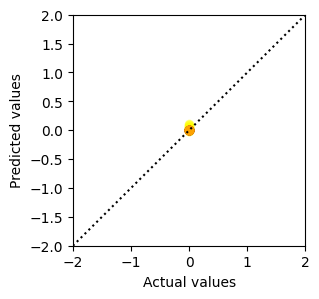

In [8]:
plt.figure(figsize=(3,3))
plt.scatter(y_test.values, predictions1a, alpha=0.4)
plt.scatter(y_test.values, predictions2a, alpha=0.4, color='red')
plt.scatter(y_test.values, predictions3a, alpha=0.4, color='green')
plt.scatter(y_test.values, predictions4a, alpha=0.4, color='yellow')
plt.scatter(y_test.values, predictions5a, alpha=0.4, color='purple')
plt.scatter(y_test.values, predictions6a, alpha=0.4, color='orange')
# plt.scatter(y_test.values, preds_baseline1, alpha=0.4, color='blue')
# plt.scatter(y_test.values, preds_baseline2, alpha=0.4, color='gray')
# plt.scatter(y_test.values, preds_baseline3, alpha=0.4, color='black')
plt.axline((0, 0), slope=1, linestyle='dotted', color='black')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.xlim([-2, 2])
plt.ylim([-2, 2])